In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [2]:

pd.set_option('display.max_rows', None)  # 모든 행 출력
pd.set_option('display.max_columns', None)  # 모든 열 출력
pd.set_option('display.width', None)  # 가로 너비 자동 조정
pd.set_option('display.max_colwidth', None)  # 긴 문자열도 모두 표시



null값 처리

In [3]:

# 1. 데이터 로드
file_path = "new_fall_data_3sec.csv"
df = pd.read_csv(file_path)

# 2. 학습에 필요한 컬럼 선택
categorical_columns = ['subject', 'status', 'interval', 'fall_stage']
numerical_columns = ['ax_kurtosis' , 'ax_time_energy', 'ax_activity_count', 
                      'ay_kurtosis',  'ay_time_energy', 'ay_activity_count',
                      'az_kurtosis','az_time_energy', 'az_activity_count']

# 3. subject별, status별, fall_stage별 평균 값으로 NaN 대체
df[numerical_columns] = df.groupby(['subject', 'status', 'fall_stage'])[numerical_columns].transform(lambda x: x.fillna(x.mean()))

# 4. 'NaN' 문자열, 빈 문자열, inf 값 처리
df[numerical_columns] = df[numerical_columns].replace(["NaN", "", " ", "nan", np.inf, -np.inf], np.nan)

# 5. 데이터 타입 변환 (모든 값을 float로 변환)
df[numerical_columns] = df[numerical_columns].apply(pd.to_numeric, errors='coerce')

# 6. NaN 값이 있으면 0으로 대체
df[numerical_columns] = df[numerical_columns].fillna(0)

# 7. 그래도 NaN이 있으면 해당 행 삭제
df = df.dropna(subset=numerical_columns, how='any')



# SMOTE적용하여 oversampling

Epoch 1/50


c:\Users\angel\anaconda3\envs\opencv312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.4432 - loss: 0.9982 - val_accuracy: 0.3984 - val_loss: 1.0371 - learning_rate: 3.0000e-04
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5458 - loss: 0.8827 - val_accuracy: 0.4922 - val_loss: 0.9997 - learning_rate: 3.0000e-04
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5522 - loss: 0.8470 - val_accuracy: 0.4141 - val_loss: 0.9788 - learning_rate: 3.0000e-04
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5819 - loss: 0.8237 - val_accuracy: 0.4297 - val_loss: 0.9601 - learning_rate: 3.0000e-04
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5527 - loss: 0.8553 - val_accuracy: 0.4453 - val_loss: 0.9503 - learning_rate: 3.0000e-04
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5681 - loss: 0.8226 - val_accuracy: 0.4453 - val_loss: 0.9405 - learning_rate: 3.0000e-04
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5487 - loss: 0.8

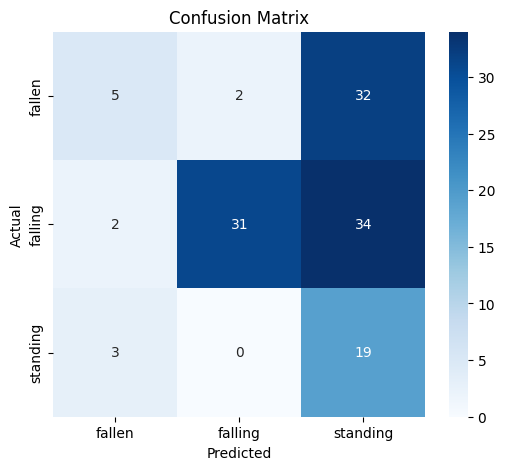

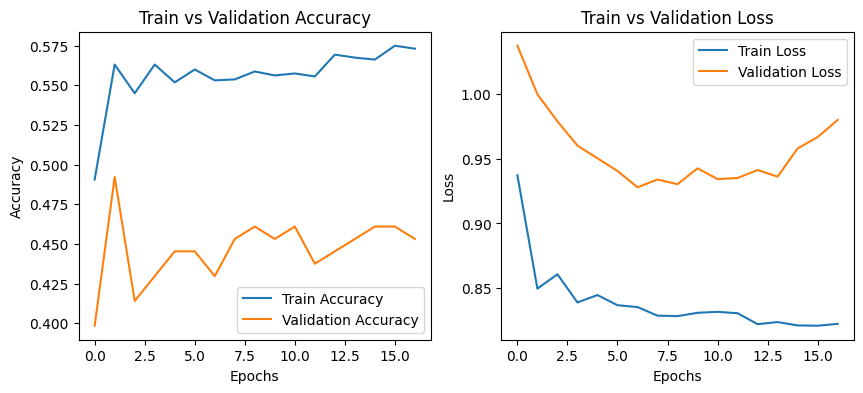

✅ 정확도(Accuracy): 0.4297
✅ 'falling' 클래스에 대한 재현율(Recall): 0.4848

🔍 Classification Report:
               precision    recall  f1-score   support

      fallen       0.50      0.13      0.20        39
     falling       0.94      0.46      0.62        67
    standing       0.22      0.86      0.36        22

    accuracy                           0.43       128
   macro avg       0.55      0.48      0.39       128
weighted avg       0.68      0.43      0.45       128



In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE

# ✅ 시간 순서 보정: time_index 추가
def add_time_index(df):
    df['time_index'] = df.groupby(['subject', 'status']).cumcount() / df.groupby(['subject', 'status']).transform('count')['interval']
    return df

# ✅ 데이터 로드 및 전처리
df = pd.read_csv("new_fall_data_3sec_clustered_time_adjusted.csv")
df = add_time_index(df)  # 시간 순서 정보 추가

# ✅ 학습 전에 `fall_stage`별 데이터 개수 출력
print("\n🔍 학습 전 `fall_stage`별 데이터 개수:")
stage_counts = df['fall_stage'].value_counts()
print(stage_counts)

# ✅ 데이터 시각화 (bar chart)
plt.figure(figsize=(6, 4))
sns.barplot(x=stage_counts.index, y=stage_counts.values, palette='viridis')
plt.xlabel("Fall Stage")
plt.ylabel("Count")
plt.title("Class Distribution Before Training")
plt.show()

# ✅ 학습에 필요한 컬럼 선택
categorical_columns = ['subject', 'status', 'interval']
numerical_columns = ['ax_spectral_entropy', 'ax_time_energy', 'ax_activity_count', 
                      'ay_kurtosis', 'ay_spectral_entropy', 'ay_time_energy', 'ay_activity_count',
                      'az_kurtosis', 'az_spectral_entropy', 'time_index']  # ⬅ time_index 추가

df_numerical = df[numerical_columns]

# 3. subject별, status별, fall_stage별 평균 값으로 NaN 대체
df[numerical_columns] = df.groupby(['subject', 'status', 'fall_stage'])[numerical_columns].transform(lambda x: x.fillna(x.mean()))

# 4. 'NaN' 문자열, 빈 문자열, inf 값 처리
df[numerical_columns] = df[numerical_columns].replace(["NaN", "", " ", "nan", np.inf, -np.inf], np.nan)

# 5. 데이터 타입 변환 (모든 값을 float로 변환)
df[numerical_columns] = df[numerical_columns].apply(pd.to_numeric, errors='coerce')

# 6. NaN 값이 있으면 0으로 대체
df[numerical_columns] = df[numerical_columns].fillna(0)

# 7. 그래도 NaN이 있으면 해당 행 삭제
df = df.dropna(subset=numerical_columns, how='any')



# ✅ 수치형 데이터 표준화
scaler = StandardScaler()
df_numerical_scaled = pd.DataFrame(scaler.fit_transform(df_numerical), columns=df_numerical.columns)

# ✅ `fall_stage` 문자열을 숫자로 변환 (Label Encoding)
label_encoder = LabelEncoder()
df['fall_stage'] = label_encoder.fit_transform(df['fall_stage'].astype(str))

# ✅ 학습 데이터 생성
X = df_numerical_scaled.values
y = df['fall_stage'].values

# ✅ Train/Test 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ✅ Oversampling (SMOTE 적용)
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# ✅ 데이터 증강 적용
def augment_timeseries_data(X, y):
    noise_factor = 0.05
    X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)
    return np.vstack([X, X_noisy]), np.hstack([y, y])

X_train_resampled, y_train_resampled = augment_timeseries_data(X_train_resampled, y_train_resampled)

# ✅ Conv1D 입력 데이터 형태 변환
X_train_resampled = X_train_resampled.reshape(-1, X_train_resampled.shape[1], 1)
X_test = X_test.reshape(-1, X_test.shape[1], 1)

# ✅ One-Hot Encoding
y_train_resampled_categorical = to_categorical(y_train_resampled)
y_test_categorical = to_categorical(y_test)

# ✅ CNN+LSTM 모델 수정 (시간 순서 보정 추가)
model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu', padding='same', input_shape=(X_train_resampled.shape[1], 1)), 
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dropout(0.4),

    Dense(32, activation='relu'),
    Dropout(0.3),

    Dense(y_train_resampled_categorical.shape[1], activation='softmax')  
])

# ✅ Adam with AMSGrad 적용
optimizer = Adam(learning_rate=0.0003, amsgrad=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ 학습률 감소 콜백
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ✅ 학습 실행
history = model.fit(X_train_resampled, y_train_resampled_categorical, 
                    validation_data=(X_test, y_test_categorical),
                    epochs=50, batch_size=32, verbose=1, 
                    shuffle=True, callbacks=[early_stopping, lr_scheduler])

# ✅ 모델 평가
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_categorical, axis=1)

# ✅ 정확도 계산
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# ✅ 'falling' 클래스에 대한 재현율(Recall) 계산
falling_recall = recall_score(y_true_classes, y_pred_classes, average='macro')

# ✅ Confusion Matrix 시각화
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ✅ 학습 및 검증 정확도 & 손실 그래프
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.show()

# ✅ 결과 출력
print(f"✅ 정확도(Accuracy): {accuracy:.4f}")
print(f"✅ 'falling' 클래스에 대한 재현율(Recall): {falling_recall:.4f}")
print("\n🔍 Classification Report:\n", classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))
